In [2]:
!pip install tntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [3]:
pip install --upgrade pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import torch

Run command
python -u script/simulation_script.py 1.5 10 3e-3 2e-3 circle 8 7

# Solving the Hydrodynamic Schrödinger Equation?

Step 0: Burgers Residual (first 5 values): [-4.82892627 -2.43836726 -0.02291041  0.01567883 -0.00837903]
--------------------------------------------------
Step 0: Velocity Gradient (first 5 values): [ 1.54819944  1.55224976  1.57351143  0.00994747 -1.5706118 ]
--------------------------------------------------
Step 0: Mean squared residual: 3.1833748536150743
--------------------------------------------------

--- Madelung Equation with a = 1.0, m = 1.0 (ℏ = 1) ---
             d                              
(v ⋅ ∇)v + ρ⋅──(v) = -∇(P + 0.25⋅∇²(log(ρ)))
             dt                             
-----------------------------------------------------

Numeric values at step 0 for a=1.0, m=1.0:
--------------------------------------------------
  Density (first 5): [9.99450997e-01 1.94686744e-04 8.48208066e-06 3.79147010e-05
 2.51538866e-09]
--------------------------------------------------
  Velocity (first 5): [-3.11905957 -1.57086013 -0.01456005  1.57616272  0.00533488]
-----------

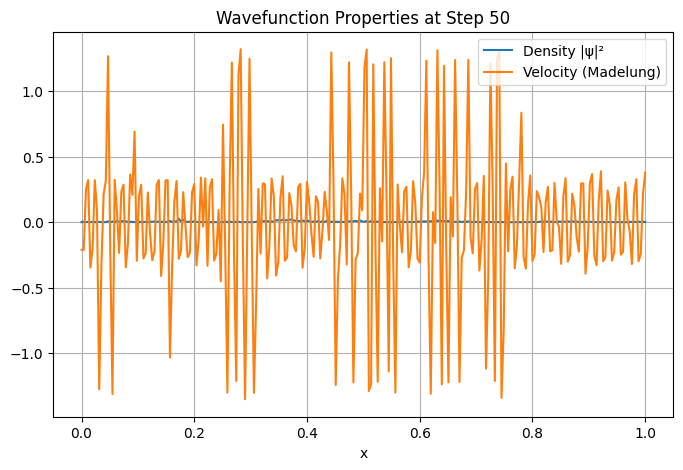

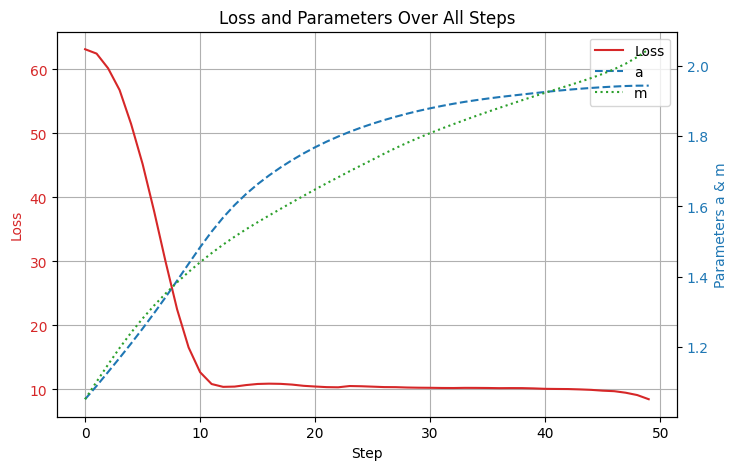

Optimization complete!
--------------------------------------------------
Final a: 1.944466, Final m: 2.048343
--------------------------------------------------
--------------------------------------------------
Step 0: Burgers Residual (first 5 values): [ 0.00000000e+00 -0.00000000e+00  1.23370055e+16 -2.46740110e+16
  1.23370055e+16]
--------------------------------------------------
Step 0: Velocity Gradient (first 5 values): [ 0.00000000e+00 -7.85398163e+07 -7.85398163e+07  1.57079633e+08
  7.85398163e+07]
--------------------------------------------------
Step 0: Mean squared residual: 9.274791382632064e+31
--------------------------------------------------

--- Madelung Equation with a = 1.0, m = 0.0 (ℏ = 1) ---
             d                             
(v ⋅ ∇)v + ρ⋅──(v) = -∇(P + zoo⋅∇²(log(ρ)))
             dt                            
-----------------------------------------------------

Numeric values at step 0 for a=1.0, m=0.0:
-----------------------------------------

In [24]:
# Import PennyLane for quantum computing
# This library provides tools for quantum circuit simulation and automatic differentiation
import pennylane as qml

# Import NumPy for numerical operations
# Used for arrays, linear algebra, random number generation, etc.
import numpy as np

# Import matplotlib for plotting
# Used for visualizing results with plots
import matplotlib.pyplot as plt

# Import sympy for symbolic math printing
# Useful for displaying equations symbolically
import sympy as sp

# Number of qubits = number of spatial discretization points
# Defines size of the quantum system
Nx = 8

# Number of layers in the ansatz circuit
# Determines depth/complexity of the quantum circuit
layers = 3

# Create quantum device simulator with Nx qubits
# This initializes a classical simulator for quantum circuits with Nx qubits
dev = qml.device("default.qubit", wires=Nx)

# Define the target Gaussian wavefunction
# This function creates a normalized Gaussian wavefunction over 2^Nx basis states
def target_wavefunction(Nx):
    # Calculate total number of basis states (2^Nx)
    num_states = 2**Nx

    # Generate spatial grid points evenly spaced from 0 to 1
    x_points = np.linspace(0, 1, num_states)

    # Set Gaussian center (mean)
    x0 = 0.5

    # Set Gaussian width (standard deviation)
    sigma = 0.1

    # Compute Gaussian amplitude at each spatial point
    amplitudes = np.exp(- (x_points - x0)**2 / (2 * sigma**2))

    # Normalize amplitudes so the wavefunction has norm 1
    psi0 = amplitudes / np.linalg.norm(amplitudes)

    # Return normalized wavefunction as a numpy array
    return psi0

# Store the target wavefunction as a PennyLane numpy array (no gradient required)
target_psi = qml.numpy.array(target_wavefunction(Nx), requires_grad=False)

# Define the layered Schrodinger ansatz circuit
# This prepares the quantum state using parameters and scalars a, m
def layered_schrodinger_ansatz(params, a, m):
    # Loop over each layer of the ansatz
    for layer in range(layers):
        # Apply parameterized rotations on each qubit
        for i in range(Nx):
            # Rotate around Y axis scaled by a * parameter
            qml.RY(a * params[layer, i, 0], wires=i)
            # Rotate around Z axis scaled by m * parameter
            qml.RZ(m * params[layer, i, 1], wires=i)
        # Entangle adjacent qubits with CNOT gates
        for i in range(Nx - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum node to run the circuit and return full statevector
@qml.qnode(dev)
def wavefunction_qnode(params, a, m):
    # Prepare the quantum state using the ansatz circuit
    layered_schrodinger_ansatz(params, a, m)
    # Return the full quantum statevector as complex amplitudes
    return qml.state()

# Madelung transform: compute density and velocity fields from quantum state
def madelung_from_state(state, m=1.0):
    # Extract complex wavefunction amplitudes
    psi = state

    # Density is squared magnitude of wavefunction
    rho = qml.math.abs(psi)**2

    # Phase angle of wavefunction (argument of complex number)
    phase = qml.math.angle(psi)

    # Compute spatial gradient of the phase
    dphase_dx = qml.math.gradient(phase)

    # Use a safe epsilon to avoid division by zero if mass near zero
    safe_m = m if abs(qml.math.toarray(m).item()) > 1e-8 else 1e-8

    # Velocity field is phase gradient divided by mass
    v = dphase_dx / safe_m

    # Return density and velocity arrays
    return rho, v

# Calculate fidelity between two quantum states
def fidelity(state1, state2):
    # Compute complex overlap between states
    overlap = qml.math.sum(qml.math.conj(state1) * state2)

    # Fidelity is absolute square of overlap amplitude
    return qml.math.abs(overlap)**2

# Compute Burgers equation residual loss from velocity field
def burgers_residual(v):
    # Compute spatial gradient of velocity
    dv_dx = qml.math.gradient(v)

    # Residual is nonlinear term v * dv/dx
    residual = v * dv_dx

    # Return mean squared residual as loss measure
    return qml.math.mean(residual**2)

# Boundary penalty to enforce zero wavefunction amplitude at edges
def boundary_penalty(state):
    # Sum squared amplitudes at first and last basis states (edges)
    penalty = qml.math.abs(state[0])**2 + qml.math.abs(state[-1])**2

    # Return penalty scalar
    return penalty

# Global counter to track optimization steps for debugging prints
global_step = 0

# Print symbolic form of Madelung equation given parameters a and m
def print_madelung_equation(a_val, m_val):
    # Define symbolic variables for density, velocity, pressure, time, and hbar
    rho, v, P, t, hbar = sp.symbols('rho v P t hbar')

    # Define symbolic Laplacian and gradient operators as functions
    laplacian = sp.Function('∇²')
    gradient = sp.Function('∇')

    # Quantum potential coefficient depending on hbar and mass m_val
    quantum_potential_coeff = (hbar**2) / (4 * m_val)

    # Quantum potential term in Madelung equation
    quantum_potential = quantum_potential_coeff * laplacian(sp.log(rho))

    # Left-hand side of the equation: time derivative of velocity and convective term
    lhs = rho * sp.Derivative(v, t) + sp.Symbol('(v ⋅ ∇)v')

    # Right-hand side: gradient of pressure plus quantum potential
    rhs = -gradient(P + quantum_potential)

    # Construct symbolic equation
    eq = sp.Eq(lhs, rhs)

    # Set reduced Planck constant hbar = 1 (natural units)
    eq = eq.subs(hbar, 1)

    # Print equation nicely
    print("\n--- Madelung Equation with a = {}, m = {} (ℏ = 1) ---".format(a_val, m_val))
    sp.pprint(eq, use_unicode=True)
    print("-----------------------------------------------------\n")

# Define total loss function combining PDE residual, fidelity, and boundary penalties
def loss_fn(params, a, m, alpha=10, beta=50):
    global global_step

    # Warn if mass parameter is dangerously close to zero
    if abs(qml.math.toarray(m).item()) < 1e-7:
        print("Warning: m is near zero, using safe epsilon")
        print("--------------------------------------------------")

    # Compute quantum state from parameters using the ansatz
    state = wavefunction_qnode(params, a, m)

    # Extract density and velocity fields from the quantum state
    rho, v = madelung_from_state(state, m)

    # Compute spatial gradient and residual for debugging output
    dv_dx = qml.math.gradient(v)
    residual = v * dv_dx

    # Every 10 steps, print debug info for residuals and gradients
    if global_step % 10 == 0:
        print(f"Step {global_step}: Burgers Residual (first 5 values): {qml.math.toarray(residual)[:5]}")
        print("--------------------------------------------------")
        print(f"Step {global_step}: Velocity Gradient (first 5 values): {qml.math.toarray(dv_dx)[:5]}")
        print("--------------------------------------------------")
        print(f"Step {global_step}: Mean squared residual: {qml.math.toarray(qml.math.mean(residual**2))}")
        print("--------------------------------------------------")

    # On first step, print symbolic Madelung equation and numeric arrays
    if global_step == 0:
        a_val = qml.math.toarray(a).item()
        m_val = qml.math.toarray(m).item()
        print_madelung_equation(a_val, m_val)
        print(f"Numeric values at step 0 for a={a_val}, m={m_val}:")
        print("--------------------------------------------------")
        print(f"  Density (first 5): {qml.math.toarray(rho)[:5]}")
        print("--------------------------------------------------")
        print(f"  Velocity (first 5): {qml.math.toarray(v)[:5]}")
        print("--------------------------------------------------")
        print(f"  Burgers Residual (first 5): {qml.math.toarray(residual)[:5]}")
        print("--------------------------------------------------")

    global_step += 1

    # Compute Burgers equation residual loss term
    burgers_loss = burgers_residual(v)

    # Compute fidelity loss to match target wavefunction
    fidelity_loss = 1 - fidelity(state, target_psi)

    # Compute boundary penalty loss for zero edge amplitudes
    boundary_loss = boundary_penalty(state)

    # Combine all losses with weighting coefficients alpha and beta
    total_loss = burgers_loss + alpha * fidelity_loss + beta * boundary_loss

    # Return combined loss value
    return total_loss

# Fix random seed for reproducibility of results
np.random.seed(42)

# Initialize ansatz parameters with small random values
params = 0.01 * np.random.randn(layers, Nx, 2)

# Convert params to PennyLane array with gradient tracking enabled
params = qml.numpy.array(params, requires_grad=True)

# Initialize scalar parameters a and m with gradient tracking
a_param = qml.numpy.array(1.0, requires_grad=True)
m_param = qml.numpy.array(1.0, requires_grad=True)

# Create Adam optimizer instance with learning rate 0.05
opt = qml.AdamOptimizer(stepsize=0.05)

# Prepare lists to store history of loss and parameters during optimization
loss_history = []
a_history = []
m_history = []

# Set number of optimization steps to run
num_steps = 50

# Generate spatial x points for plotting density and velocity (2^Nx points)
plotting_x_points = np.linspace(0, 1, 2**Nx)

# Enable interactive mode for live updating plots
plt.ion()

# Create a single subplot figure for plotting wavefunction properties
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Optimization loop over defined number of steps
for step in range(num_steps):
    # Save old values for printing changes
    old_a = qml.math.toarray(a_param).item()
    old_m = qml.math.toarray(m_param).item()

    # Define cost function wrapper for optimizer input
    def cost(p, a_, m_):
        return loss_fn(p, a_, m_)

    # Perform one optimization step updating params, a_param, m_param simultaneously
    (params, a_param, m_param), curr_loss = opt.step_and_cost(cost, params, a_param, m_param)

    # Get new values for printing changes
    new_a = qml.math.toarray(a_param).item()
    new_m = qml.math.toarray(m_param).item()

    # Append current loss and parameter values to history lists
    loss_history.append(qml.math.toarray(curr_loss).item())
    a_history.append(new_a)
    m_history.append(new_m)

    # Print optimization progress with changes to a and m
    print(f"Step {step + 1:02d}: Loss={curr_loss:.6f}, a: {old_a:.6f} -> {new_a:.6f}, m: {old_m:.6f} -> {new_m:.6f}")
    print("--------------------------------------------------")

    # Clear current axes for fresh plotting
    axs.cla()

    # Compute state and Madelung variables for plotting
    state = wavefunction_qnode(params, a_param, m_param)
    rho, v = madelung_from_state(state, m_param)

    # Plot current density and velocity on x axis
    axs.plot(plotting_x_points, rho, label='Density |ψ|²')
    axs.plot(plotting_x_points, v, label='Velocity (Madelung)')

    # Set plot title and axis labels
    axs.set_title(f'Wavefunction Properties at Step {step + 1}')
    axs.set_xlabel('x')

    # Display legend and grid for readability
    axs.legend()
    axs.grid(True)

    # Refresh plot canvas to update visualization
    fig.canvas.draw()
    fig.canvas.flush_events()

# Disable interactive plotting mode after optimization completes
plt.ioff()

# Create final static plot showing loss and parameter history over all steps
plt.figure(figsize=(8, 5))

# Get current axis for plotting loss
ax1 = plt.gca()

# Plot loss values over steps with red color
ax1.plot(loss_history, color='tab:red', label='Loss')

# Label x-axis and y-axis for loss
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color='tab:red')

# Set y-axis tick color and enable grid lines
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True)

# Create secondary y-axis to plot parameters a and m on different scale
ax2 = ax1.twinx()

# Plot parameter 'a' history with blue dashed line
ax2.plot(a_history, color='tab:blue', linestyle='--', label='a')

# Plot parameter 'm' history with green dotted line
ax2.plot(m_history, color='tab:green', linestyle=':', label='m')

# Label secondary y-axis for parameters
ax2.set_ylabel('Parameters a & m', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends from both y-axes into one
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Set overall plot title and display it
plt.title("Loss and Parameters Over All Steps")
plt.show()

# Print completion message with final optimized parameters
print("Optimization complete!")
print("--------------------------------------------------")
print(f"Final a: {a_param:.6f}, Final m: {m_param:.6f}")
print("--------------------------------------------------")

# --- Now run comparison for fixed (a, m) = (1, 0) with debug prints ---

# Reset global step counter to print debug info in loss_fn
global_step = 0

# Define fixed scalar parameters to compare against
fixed_a = 1.0
fixed_m = 0.0

# Compute loss with fixed parameters (a=1, m=0) for comparison
comparison_loss = loss_fn(params, fixed_a, fixed_m)

# Print comparison loss result
print("\nComparison output for (a, m) = (1, 0):")
print("--------------------------------------------------")
print(f"Loss: {qml.math.toarray(comparison_loss).item():.6f}")
print("--------------------------------------------------")